In [14]:
import os
import pandas as pd

root_dir = "/home/youlee/n24news/n24news/caption"

data = []

for folder_name in sorted(os.listdir(root_dir)):
    folder_path = os.path.join(root_dir, folder_name)
    if os.path.isdir(folder_path):  
        
        caption_file = os.path.join(folder_path, "caption.txt")
        label_file = os.path.join(folder_path, "label.txt")
        
        if os.path.exists(caption_file) and os.path.exists(label_file):
        
            with open(caption_file, "r", encoding="utf-8") as cf:
                caption = cf.read().strip()
            with open(label_file, "r", encoding="utf-8") as lf:
                label = lf.read().strip()
            
            data.append({"Folder": folder_name, "Caption": caption, "Label": label})

df = pd.DataFrame(data)
df


,Folder,Caption,Label
0,caption_1,Danai Gurira and André Holland in a theater at...,Theater
1,caption_10,The White House is a classical style piece of ...,Art & Design
2,caption_100,Tobi Tobias in an undated photo. A finalist fo...,Dance
3,caption_1000,"Billie Eilish performed ""No Time to Die,"" her ...",Music
4,caption_10000,An H&M clothing store being built on the Fulto...,Real Estate
...,...,...,...
48983,caption_9995,"""It's patriotic to speak out about the injusti...",Movies
48984,caption_9996,Buttery breakfast casserole.,Food
48985,caption_9997,Coco Mathieson and Callum Linnane in Alice Top...,Dance
48986,caption_9998,One of Uber's self-driving cars. The company i...,Technology


- n24news 논문에서 text classification 하이퍼파라미터 세팅
    - Batch Size: 32
    - Learning Rate: 1e-5 
    - Optimizer: Adam
    - Loss Function: Cross-Entropy Loss
    - 텍스트 최대 길이 (Maximum Sequence Length): 512
    - 이미지 입력 크기: 224×224

In [15]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [16]:
MAX_LENGTH = 512  # 입력 텍스트의 최대 토큰 길이
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = pd.read_csv('/home/youlee/n24news/n24news/captions_and_labels.csv')  
df['Caption'] = df['Caption'].fillna("").astype(str)  
df['Label'] = LabelEncoder().fit_transform(df['Label']) 

def tokenize_data(df):
    input_ids, attention_masks = [], []
    for text in df['Caption']:
        encoded = tokenizer(text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)

input_ids, attention_masks = tokenize_data(df)
labels = torch.tensor(df['Label'].values)

In [17]:
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

dataset = CustomDataset(input_ids, attention_masks, labels)

In [18]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
class CrossAttention(nn.Module):
    def __init__(self, d_in, d_out_kq, d_out_v):
        super(CrossAttention, self).__init__()
        self.key_proj = nn.Linear(d_in, d_out_kq)
        self.query_proj = nn.Linear(d_in, d_out_kq)
        self.value_proj = nn.Linear(d_in, d_out_v)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, latent):
        keys = self.key_proj(x)
        queries = self.query_proj(latent)
        values = self.value_proj(x)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_probs = self.softmax(attention_scores)

        attended_values = torch.matmul(attention_probs, values)
        return attended_values

class LatentTransformer(nn.Module):
    def __init__(self, latent_dim, num_heads, num_layers, embed_dim):
        super(LatentTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, latent):
        latent = latent.permute(1, 0, 2)
        latent = self.transformer(latent)
        return latent.permute(1, 0, 2)

class Averaging(nn.Module):
    def forward(self, latent):
        return latent.mean(dim=1)

class Perceiver(nn.Module):
    def __init__(self, vocab_size, embed_dim, latent_dim, num_heads, num_layers, num_classes):
        super(Perceiver, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.input_proj = nn.Linear(embed_dim, embed_dim)
        self.latents = nn.Parameter(torch.randn(1, latent_dim, embed_dim))
        self.cross_attention = CrossAttention(d_in=embed_dim, d_out_kq=embed_dim, d_out_v=embed_dim)
        self.latent_transformer = LatentTransformer(latent_dim=latent_dim, num_heads=num_heads,
                                                    num_layers=num_layers, embed_dim=embed_dim)
        self.averaging = Averaging()
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.input_proj(x)

        batch_size = x.size(0)
        latent = self.latents.repeat(batch_size, 1, 1)
        latent = self.cross_attention(x, latent)
        latent = self.latent_transformer(latent)
        latent_avg = self.averaging(latent)
        logits = self.classifier(latent_avg)
        return logits

In [20]:
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
NUM_HEADS = 8
NUM_LAYERS = 4
NUM_CLASSES = len(df['Label'].unique())

model = Perceiver(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, latent_dim=LATENT_DIM,
                  num_heads=NUM_HEADS, num_layers=NUM_LAYERS, num_classes=NUM_CLASSES)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Perceiver(
  (embedding): Embedding(30522, 128)
  (input_proj): Linear(in_features=128, out_features=128, bias=True)
  (cross_attention): CrossAttention(
    (key_proj): Linear(in_features=128, out_features=128, bias=True)
    (query_proj): Linear(in_features=128, out_features=128, bias=True)
    (value_proj): Linear(in_features=128, out_features=128, bias=True)
    (softmax): Softmax(dim=-1)
  )
  (latent_transformer): LatentTransformer(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Learning Rate Decay 설정
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [22]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [23]:
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


In [24]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{EPOCHS}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}')

    # Learning Rate Decay 업데이트
    scheduler.step()

Epoch 1/10:
  Train Loss: 2.9312, Train Acc: 0.1218
  Test Loss: 2.7662, Test Acc: 0.1840
Epoch 2/10:
  Train Loss: 2.7073, Train Acc: 0.2025
  Test Loss: 2.6427, Test Acc: 0.2239
Epoch 3/10:
  Train Loss: 2.6211, Train Acc: 0.2343
  Test Loss: 2.6145, Test Acc: 0.2352
Epoch 4/10:
  Train Loss: 2.6075, Train Acc: 0.2378
  Test Loss: 2.6029, Test Acc: 0.2388
Epoch 5/10:
  Train Loss: 2.5991, Train Acc: 0.2406
  Test Loss: 2.6017, Test Acc: 0.2383
Epoch 6/10:
  Train Loss: 2.5977, Train Acc: 0.2403
  Test Loss: 2.6006, Test Acc: 0.2399
Epoch 7/10:
  Train Loss: 2.5968, Train Acc: 0.2416
  Test Loss: 2.6005, Test Acc: 0.2398
Epoch 8/10:
  Train Loss: 2.5973, Train Acc: 0.2414
  Test Loss: 2.6004, Test Acc: 0.2398
Epoch 9/10:
  Train Loss: 2.5971, Train Acc: 0.2406
  Test Loss: 2.6004, Test Acc: 0.2398
Epoch 10/10:
  Train Loss: 2.5969, Train Acc: 0.2410
  Test Loss: 2.6004, Test Acc: 0.2398


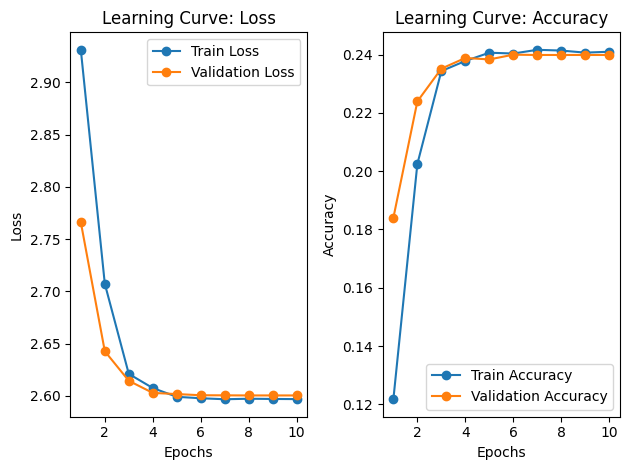

In [27]:
# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve: Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, EPOCHS+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

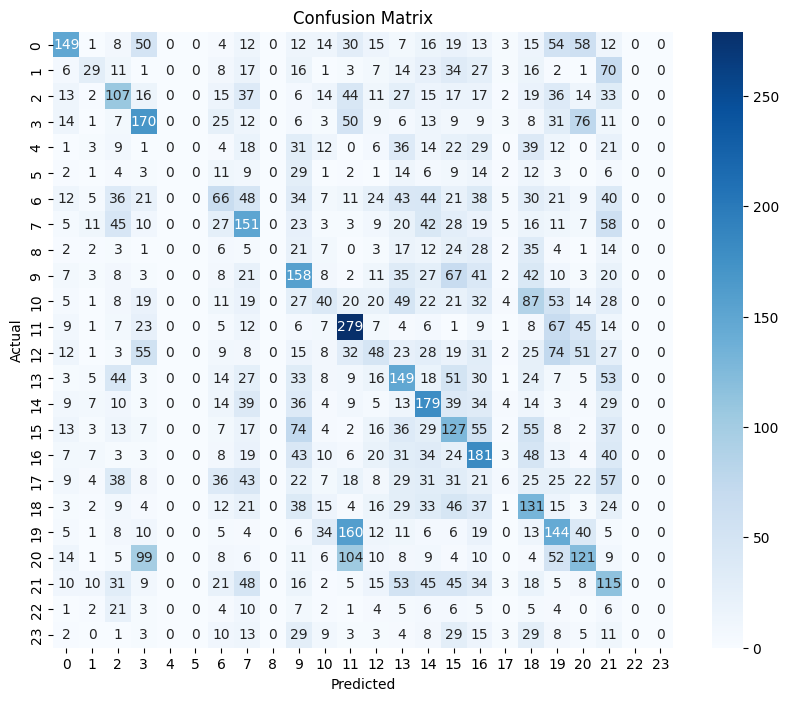

In [26]:
# Confusion Matrix 시각화
def visualize_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

class_names = LabelEncoder().fit(df['Label']).classes_
visualize_confusion_matrix(model, test_loader, device, class_names)